In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import plotly.graph_objects as go
from datetime import datetime, time
try:
    from zoneinfo import ZoneInfo
    IST = ZoneInfo("Asia/Kolkata")
except:
    IST = None


In [2]:
ps = pd.read_csv("Downloads/Play Store Data.csv")


In [3]:
ps

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


In [4]:
def parse_installs(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).replace('+','').replace(',','').strip()
    return pd.to_numeric(s, errors='coerce')

def parse_size(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if "Varies" in s:
        return np.nan
    if s.lower().endswith("m"):
        return pd.to_numeric(s[:-1], errors='coerce') * 1_000_000
    if s.lower().endswith("k"):
        return pd.to_numeric(s[:-1], errors='coerce') * 1_000
    return pd.to_numeric(s, errors='coerce')


In [5]:
colmap = {
    "App":"app",
    "Category":"category",
    "Rating":"rating",
    "Reviews":"reviews",
    "Installs":"installs",
    "Size":"size",
    "Last Updated":"last_updated"
}
for o,n in colmap.items():
    if o in ps.columns:
        ps.rename(columns={o:n}, inplace=True)

ps["rating"]   = pd.to_numeric(ps.get("rating"), errors="coerce")
ps.loc[(ps["rating"] < 0) | (ps["rating"] > 5), "rating"] = np.nan
ps["reviews"]  = pd.to_numeric(ps.get("reviews"), errors="coerce")
ps["installs"] = ps.get("installs").apply(parse_installs)
ps["size_b"]   = ps.get("size").apply(parse_size)
ps["last_dt"]  = pd.to_datetime(ps.get("last_updated"), errors="coerce")
ps["last_mon"] = ps["last_dt"].dt.month


In [6]:
df = ps.copy()
df = df[df["size_b"] >= 10_000_000]
df = df[df["last_mon"] == 1]

In [7]:
# group rating > 4.0 top 10 installs
grp = (
    df.groupby("category", as_index=False)
      .agg(
        avg_rating=("rating","mean"),
        total_reviews=("reviews","sum"),
        total_installs=("installs","sum")
      )
)

grp = grp[grp["avg_rating"] >= 4.0].dropna(subset=["total_installs"])
grp = grp.sort_values("total_installs", ascending=False).head(10)
grp


,category,avg_rating,total_reviews,total_installs
9,FAMILY,4.185714,4737822.0,199721180.0
25,SPORTS,4.342857,1982017.0,120511100.0
12,GAME,4.251515,2412245.0,117291000.0
7,ENTERTAINMENT,4.250000,1238948.0,51000000.0
20,PERSONALIZATION,4.475000,156004.0,15061000.0
15,LIFESTYLE,4.050000,53376.0,6171560.0
23,SHOPPING,4.200000,19950.0,2000000.0
6,EDUCATION,4.400000,57645.0,2000000.0
4,COMMUNICATION,4.050000,15398.0,1011000.0
0,ART_AND_DESIGN,4.100000,2167.0,620000.0


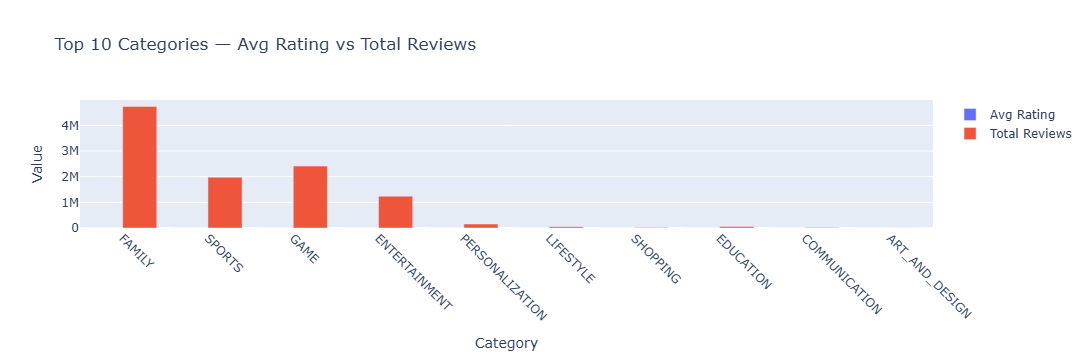

In [8]:
def allowed_time():
    now_t = datetime.now(IST).time() if IST else datetime.now().time()
    return time(15,0) <= now_t <= time(17,0)

if not grp.empty and allowed_time():
    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=grp["category"], 
        y=grp["avg_rating"], 
        name="Avg Rating"
    ))

    fig.add_trace(go.Bar(
        x=grp["category"],
        y=grp["total_reviews"],
        name="Total Reviews"
    ))

    fig.update_layout(
        title="Top 10 Categories — Avg Rating vs Total Reviews",
        barmode="group",
        xaxis=dict(title="Category", tickangle=45),
        yaxis=dict(title="Value")
    )
    fig.show()
# If the time is not 3-5 PM , no graph will be displayed.
